## 加载数据集

In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import numpy as np
from tqdm import tqdm
import cv2
import os

np.random.seed(2018)

os.chdir("{}/../image".format(os.getcwd())) 

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(int(n/2))):
    X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' % i), (224, 224))
    X[i+int(n/2)] = cv2.resize(cv2.imread('train/dog.%d.jpg' % i), (224, 224))

y[int(n/2):] = 1

Using TensorFlow backend.
100%|██████████| 12500/12500 [01:40<00:00, 124.19it/s]


## 分为训练集和验证集

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## 构建模型

In [3]:
base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 训练模型

In [5]:
model.fit(X_train, y_train, batch_size=16, nb_epoch=5, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 23829s - loss: 0.1547 - acc: 0.9404 - val_loss: 0.0564 - val_acc: 0.9818
Epoch 2/5
20000/20000 [==============================] - 19640s - loss: 0.0872 - acc: 0.9670 - val_loss: 0.0462 - val_acc: 0.9836
Epoch 3/5
20000/20000 [==============================] - 25505s - loss: 0.0813 - acc: 0.9685 - val_loss: 0.0435 - val_acc: 0.9836
Epoch 4/5
20000/20000 [==============================] - 20431s - loss: 0.0772 - acc: 0.9695 - val_loss: 0.0421 - val_acc: 0.9838
Epoch 5/5
20000/20000 [==============================] - 24864s - loss: 0.0755 - acc: 0.9708 - val_loss: 0.0419 - val_acc: 0.9834


In [6]:
model.save('ResNet50_catdog_model.h5')

## 可视化模型

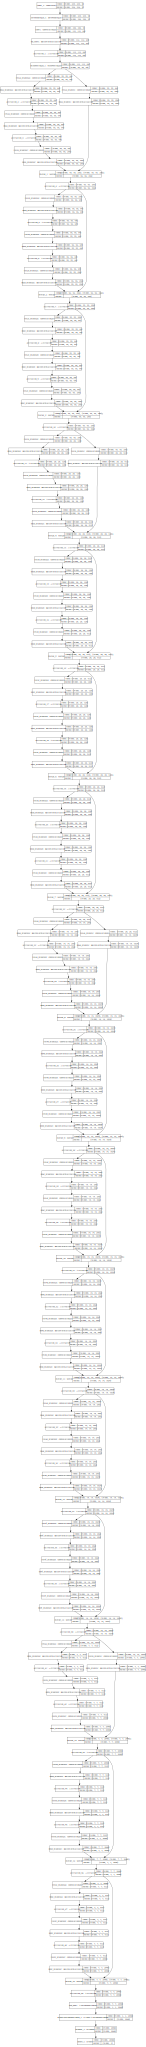

In [9]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot, plot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
zip([x.name for x in model.layers], range(len(model.layers)))

In [11]:
weights = model.layers[177].get_weights()[0]
model2 = Model(model.input, [model.layers[172].output, model.output])

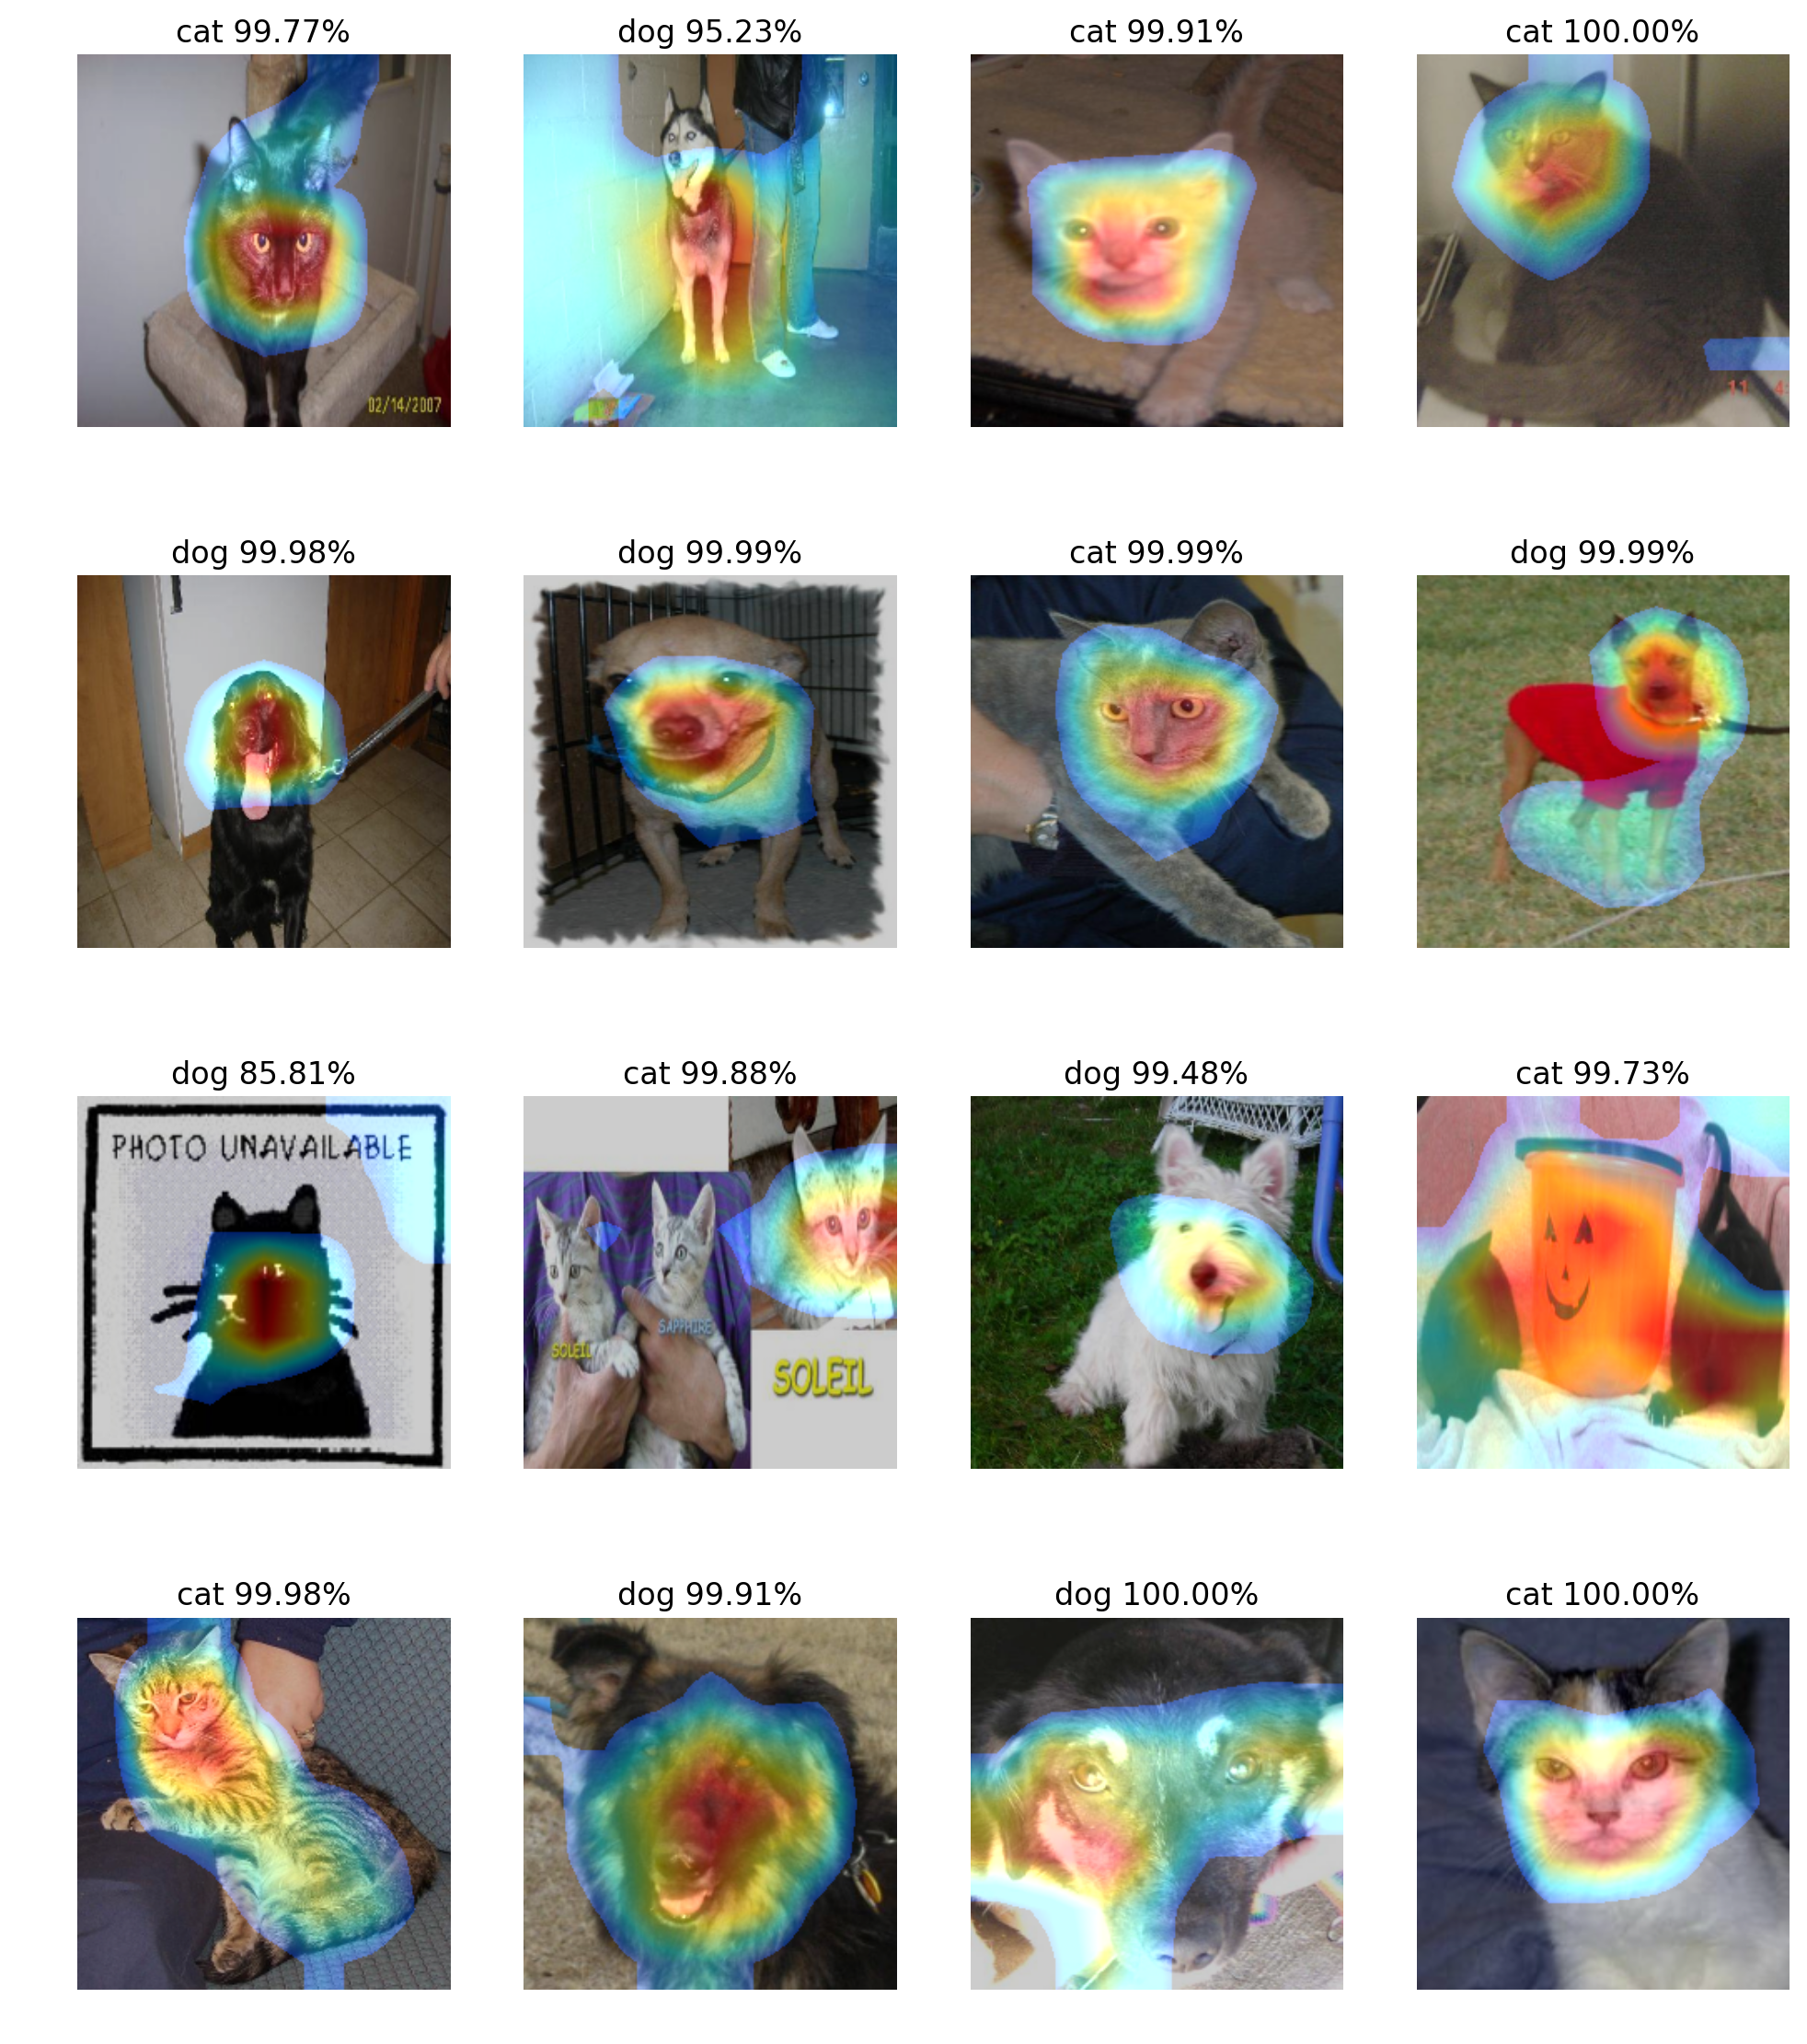

In [12]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model2.predict(np.expand_dims(x, axis=0))

    prediction = prediction[0]
    out = out[0]

    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])